# MEI Main Code

## Settings

### Auxiliary funcs

In [1]:
# Generic Imports
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt 
# import ipywidgets as widget
# from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider
import torch.optim as optim
from scipy import ndimage, signal

from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# show figures inline
# %matplotlib inline

num_gpus_available = torch.cuda.device_count()
print("Number of available GPUs:", num_gpus_available)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Number of available GPUs: 1
cuda


In [2]:
def myimshow(I, type="rel", figsize=(5,5), title=None, save=False, info=None, label=None, **kwargs):
    # utility function to show image
    plt.figure(figsize=figsize);
    if title != None:
        plt.title(title)
    plt.axis('off')
    # plt.imshow(I, cmap="gray", **kwargs)
    vmin, vmax = None, None
    if type == "abs":
        vmin, vmax = 0, 255
    plt.imshow(I, cmap="gray", vmin=vmin, vmax=vmax,
                #  aspect='auto',
                 **kwargs)
    if save:
        plt.title(info)
        plt.savefig("./dev/images/image-"+label+".png")


In [3]:
def rescale_images(images, low=0, high=1, together=True):
    #rescales pixel value in the range [low,high]
    axis = None if together else (1, 2)
    images = images - images.min(axis=axis, keepdims=True)
    images = images / images.max(axis=axis, keepdims=True) * (high - low) + low
    return images

In [4]:
def adjust_contrast(img, contrast=-1, mu=-1, img_min=0, img_max=255, force=True, verbose=False, steps=5000):
    """
    Performs contrast adjustment of the image, being mindful of the image value bounds (e.g. [0, 255]). Given the bounds
    the normal shift and scale will not guarantee that the resulting image still has the desired mean luminance
    and contrast.
    Args:
        img: image to adjsut the contrast
        contrast: desired contrast - this is taken to be the RMS contrast
        mu: desired mean value of the final image
        img_min: the minimum pixel intensity allowed
        img_max: the maximum pixel intensity allowed
        force: if True, iterative approach is taken to produce an image with the desired stats. This will likely cause
        some pixels to saturate in the upper and lower bounds. If False, then image is scaled simply based on ratio of
        current and desired contrast, and then clipped. This likely results in an image that is higher in contrast
        than the original but not quite at the desired contrast and with some pixel information lost due to clipping.
        verbose: If True, prints out progress during iterative adjustment
        steps: If force=True, this sets the number of iterative steps to be used in adjusting the image. The larger the
        value, the closer the final image would approach the desired contrast.

    Returns:
        adjusted_image - a new image adjusted from the original such that the desired mean/contrast is achieved to the
            best of the configuration.
        clipped - Whether any clipping took place. If True, it indicates that some clipping of pixel intensities occured
            and thus some pixel information was lost.
        actual_contrast - the final contrast of the image reached


    """
    current_contrast = img.std()

    if contrast < 0:
        gain = 1   # no adjustment of contrast
    else:
        gain = contrast / current_contrast

    delta = img - img.mean()
    if mu is None or mu < 0: # no adjustment of mean
        mu = img.mean()

    min_pdist = delta[delta > 0].min()
    min_ndist = (-delta[delta < 0]).min()

    # point beyond which scaling would completely saturate out the image (e.g. all pixels would be completely black or
    # white)
    max_lim_gain = max((img_max - mu) / min_pdist, (mu - img_min) / min_ndist)

    vmax = delta.max()
    vmin = delta.min()

    # maximum gain that could be used without losing image information
    max_gain = min((img_max - mu) / vmax, (img_min-mu) / vmin)

    # if True, we already know that the desired contrast cannot be achieved without losing some pixel information
    # into the saturation regime
    clipped = gain > max_gain

    v = np.linspace(0, (img_max-img_min), steps) # candidates for mean adjustment
    if clipped and force:
        if verbose:
            print('Adjusting...')
        cont = []
        imgs = []
        gains = np.logspace(np.log10(gain), np.log10(max_lim_gain), steps)
        # for each gain, perform offset adjustment such that the mean is equal to the set value
        for g in gains:
            img = delta * g + mu
            img = np.clip(img, img_min, img_max)
            offset = img.mean() - mu # shift in clipped image mean caused by the clipping
            if offset < 0: # pixel values needs to be raised
                offset = -offset
                mask = (img_max-img < v[:, None, None])
                nlow = mask.sum(axis=(1, 2)) # pixels that are closer to the bound than v
                nhigh = img.size - nlow
                # calculate the actual shift in mean that can be achieved by shifting all pixels by v
                # then clipping
                va = ((mask * (img_max-img)).sum(axis=(1, 2)) + v * nhigh) / (nlow + nhigh)

                # find the best candidate offset that achieves closest to the desired shift in the mean
                pos = np.argmin(np.abs(va - offset))
                actual_offset = -v[pos]
            else:
                mask = (img-img_min < v[:, None, None])
                nlow = mask.sum(axis=(1, 2))
                nhigh = img.size - nlow
                # actual shift in mean that can be achieved by shifting all pixels by v
                va = ((mask * (img-img_min)).sum(axis=(1, 2)) + v * nhigh) / (nlow + nhigh)
                pos = np.argmin(np.abs(va - offset))
                actual_offset = v[pos]


            img = img - actual_offset
            img = np.clip(img, img_min, img_max)
            # actual contrast achieved with this scale and adjustment
            c = img.std()
            cont.append(c)
            imgs.append(img)
            if c > contrast:
                break
        loc = np.argmin(np.abs(np.array(cont) - contrast))
        adj_img = imgs[loc]
    else:
        adj_img = delta * gain + mu
        adj_img = np.clip(adj_img, img_min, img_max)
    actual_contrast = adj_img.std()
    return adj_img, clipped, actual_contrast

In [5]:
def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False, info='', interval=50):
    ncols = max(1,n_sample//nrows)
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                             # change to Numpy image format to (h,w,channels) vs (channels,h,w)
    # nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow
    nsx_gen_store = sx_gen_store
    
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize = (4*ncols, 4*nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                if ncols*nrows != 1 and nrows != 1:
                    axs[row, col].clear()
                    axs[row, col].set_xticks([])
                    axs[row, col].set_yticks([])
                    plots.append(axs[row, col].imshow(store[i,(row*ncols)+col], vmax=255, vmin=0,
                                                    #    aspect='auto',
                                                       cmap="gray"))
                elif ncols*nrows != 1 and nrows == 1:
                    axs[col].clear()
                    axs[col].set_xticks([])
                    axs[col].set_yticks([])
                    plots.append(axs[col].imshow(store[i,col], vmax=255, vmin=0,
                                                #   aspect='auto',
                                                  cmap="gray"))
                else:
                    axs.clear()
                    axs.set_yticks([])
                    axs.set_xticks([])
                    plots.append(axs.imshow(store[i,col], vmax=255, vmin=0,
                                            # aspect='auto',
                                            cmap="gray"))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=interval, blit=False, repeat=True, frames=nsx_gen_store.shape[0]) 
    plt.close()
    if save:
        ani.save(save_dir + f"animation{info}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani

In [6]:
def create_gabor(sz=(90,60), phase=0, wavelength=np.pi, orientation=45.0, sigma=5,
                 dy=0, dx=0):
    """ Create a gabor patch (sinusoidal + gaussian).

    Arguments:
        height (int): Height of the image in pixels.
        width (int): Width of the image in pixels.
        phase (float): Angle at which to start the sinusoid in degrees.
        wavelength (float): Wavelength of the sinusoid (1 / spatial frequency) in pixels.
        orientation (float): Counterclockwise rotation to apply (0 is horizontal) in
            degrees.
        sigma (float): Sigma of the gaussian mask used in pixels
        dy (float): Amount of translation in y (positive moves down) in pixels/height.
        dx (float): Amount of translation in x (positive moves right) in pixels/height.

    Returns:
        Array of height x width shape with the required gabor.
    """
    if isinstance(sz, (int, float)):
        height, width = int(sz), int(sz)
    elif isinstance(sz, tuple) and len(sz) == 2:
        height, width = int(sz[0]), int(sz[1])
    
    # Compute image size to avoid translation or rotation producing black spaces
    padding = max(height, width)
    imheight = height + 2 * padding
    imwidth = width + 2 * padding
    # we could have diff pad sizes per dimension = max(dim_size, sqrt((h/2)^2 + (w/2)^2))
    # but this simplifies the code for just a bit of inefficiency

    # Create sinusoid with right wavelength and phase
    start_sample = phase
    step_size = 360 / wavelength
    samples = start_sample + step_size * np.arange(imheight)
    samples = np.mod(samples, 360)  # in degrees
    rad_samples = samples * (np.pi / 180)  # radians
    sin = np.sin(rad_samples)

    # Create Gabor by stacking the sinusoid along the cols
    gabor = np.tile(sin, (imwidth, 1)).T

    # Rotate around center
    gabor = ndimage.rotate(gabor, orientation, reshape=False)

    # Apply gaussian mask, its is normalized to take values in [0,1]
    gaussy = signal.windows.gaussian(imheight, std=sigma)
    gaussx = signal.windows.gaussian(imwidth, std=sigma)
    mask = np.outer(gaussy, gaussx)
    gabor = gabor * mask

    # Translate (this is only approximate but it should be good enough)
    if abs(dx) > 1 or abs(dy) > 1:
        raise ValueError('Please express translations as factors of the height/width,'
                         'i.e, a number in interval [-1, 1] ')
    dy = int(dy * height)  # int is the approximation
    dx = int(dx * width)
    gabor = gabor[padding - dy: -padding - dy, padding - dx: -padding - dx]

    if gabor.shape != (height, width):
        raise ValueError('Dimensions of gabor do not match desired dimensions.')

    return gabor.astype(np.float32)

In [7]:
# def Loss_fn1(image, device='cpu', penalty=False, norm=True, lambda_factor=2000, target=16.0, **kwargs):
#     # kwargs are passed to create_gabor: phase=0, wavelength=10, orientation=0, sigma=5, dy=0, dx=0

#     # Gabor function applied to (x,y) grid centered in (0,0) of size "sz"  /  2D Tensor [sz,sz]
#     height, width = image.size()
#     D = torch.tensor(create_gabor(sz=(height, width), **kwargs)).to(device)

#     # Component-wise multiplication, normalized by number of pixels  /  2D Tensor [sz,sz]
#     prod = torch.mul(D,image)
    
#     # Compute the sum over both x and y
#     result = torch.sum(prod)

#     if norm:
#         result = result * (1/(height*width))

#     if penalty:
#         result = result - lambda_factor * penalty1(image, target)

#     return result

In [8]:
def fft_filter(grad):
    return grad

In [9]:
# def penalty1(image, target=16.0):
#     assert image.min()>=0, "Image needs rescaling"
#     assert image.max()<=255, "image needs rescaling"
    
#     # Measure current contrast with RMS
#     contrast = image.std()
#     penalty = torch.abs(contrast-target)
#     return penalty

In [10]:
# def GD(sz=3, 
#        step=100, n_epoch=200, 
#        loss_fn=Loss_fn1, fft_filter=fft_filter,
#        smooth_check=False, blurr_check=False, blur=1, 
#        penalty=False, lambda_factor=100 , target=16.0, 
#        verbose=False, picture=0, 
#        **kwargs):
    
#     torch.manual_seed(42)

#     if isinstance(sz, (int, float)):
#         height, width = int(sz), int(sz)
#     elif isinstance(sz, tuple) and len(sz) == 2:
#         height, width = int(sz[0]), int(sz[1])

#     # Select what device we are using
#     device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#     print("device: ", device)

#     # Initialize the starting point: a (sz,sz) tensor with random integers from 0 to 255 (8 bit grayscale) 
#     # converted as float to satisfy backpropagation requirements and moved to device

#     image = torch.randint(0, 255, (height,width)).float().to(device)
#     controll = image.clone()    # Controll image, we do not apply any denoising

#     # Keeps Track of image progress during ascent
#     log1 = []   # For image
#     log0 = []   # For controll

#     # Set requires grad to true
#     image.requires_grad_(True)
    

#     #----------------
#     # Take a look at the random integer we started with
#     if verbose:
#         if picture == 2:
#             myimshow(image.cpu().detach().numpy(), "abs", title="START")
#     #^^^^^^^^^^^^^^^^

#     # Iterate for n_epoch times the gradient steps
#     for epoch in range(n_epoch):
#         image.requires_grad_(True)
#         controll.requires_grad_(True)

#         # Compute loss function of image 
#         loss = loss_fn(image=image, device=device, penalty=penalty, lambda_factor=lambda_factor, target=target, **kwargs)
#         loss_controll = loss_fn(image=controll, device=device, penalty=penalty, lambda_factor=lambda_factor, target=target, **kwargs)

#         sigma = blur + ((0.001 - blur) * epoch) / n_epoch
#         step = step + ((2650 - step) * epoch) / n_epoch

#         #----------------
#         # Checking the loss at each iteration
#         if verbose:
#             if n_epoch <= 10:
#                 print('Epoch:', epoch, 'Loss:', loss.item())

#             elif n_epoch <= 100:
#                 if epoch%10 == 0:
#                     print('Epoch:', epoch, 'Loss:', loss.item())

#             elif n_epoch <= 1000:
#                 if epoch%100 == 0:
#                     print('Epoch:', epoch, 'Loss:', loss.item())

#             else:
#                 if epoch%500 == 0:
#                     print('Epoch:', epoch, 'Loss:', loss.item())
#         #^^^^^^^^^^^^^^^^

#         # Compute gradients
#         loss.backward()
#         loss_controll.backward()


#         # We don't want to include the update in the gradient computation
#         with torch.no_grad():

#             grad = image.grad
#             grad_controll = controll.grad
            
#             # Gradient Smoothing using Fast Fourier Filter on frequencies; part of high frequencies denoise
#             if smooth_check:
#                 grad = fft_filter(image.grad)

#             # Proceed with the step: adding the gradient to the imag
#             image += step * grad
#             controll += step * grad_controll

#             # Zeroing the grad for next iteration 
#             image.grad.zero_()
#             controll.grad.zero_()

#             # Blurr image if blurr_check; part of high frequencies denoise
#             if blurr_check:
#                 image = torch.tensor(ndimage.gaussian_filter(image.cpu(), sigma, order=0)).to(device)

#             # Clamp the obtained image so that pixel saty in the domain [0,255]
#             image.clamp_(0,255)
#             controll.clamp_(0,255)

#             #----------------
#             # Store image every n iterations
#             if epoch % 10 == 0:
#                 log1.append(image.unsqueeze(0).unsqueeze(0).detach().cpu().numpy())
#                 log0.append(controll.unsqueeze(0).unsqueeze(0).detach().cpu().numpy())
#             #^^^^^^^^^^^^^^^^


#     #----------------
#     # we finished GD, let's see the results
#     if verbose:
#         if picture:
#             myimshow(image.cpu().detach().numpy(), "abs", title="END")
#         print("Current Contrast: ", round(image.std().item(), 3))
#     #^^^^^^^^^^^^^^^^

#     #----------------
#     # and check our result against the true
#     if verbose:
#         if picture:
#             myimshow(create_gabor(sz=sz,**kwargs), "rel", title="Controll")
#         true = rescale_images(create_gabor(sz=sz,**kwargs), 0,255)
#         print("Control Contrast: ",round(true.std(), 3))
#     #^^^^^^^^^^^^^^^^

#     log1 = np.stack(log1)
#     log0 = np.stack(log0)
#     log = np.concatenate((log1,log0), axis = 1)
#     return log

### Model Imports

In [11]:
import json
import os
import torch
from scripts.utils import create_data_paths, JSONArgs, Args
from corticalpy.models.utils.loading import mouse_video_loader
from corticalpy.models.utils.build import build_encoder
from corticalpy.models.utils.scheduler import Scheduler

### Configuration

In [12]:
class Args:
    
    def __init__(self):
        self.output_dir = None
        self.model_name = None
        self.dataset = None

In [13]:
args = Args()

In [14]:
args.output_dir = 'save/models'
args.model_name = 'bocconi10'

In [15]:
if os.getcwd() != '/workspaces/microns_phase3_nda':
    os.chdir("..")
print(os.getcwd())

/workspaces/microns_phase3_nda


In [16]:
args.output_dir = os.path.join(args.output_dir, args.model_name)

if os.path.exists(os.path.join(args.output_dir, 'args.json')):
    with open(os.path.join(args.output_dir, 'args.json'), 'r') as j:
        contents = json.loads(j.read())
        args = JSONArgs(**contents)

In [17]:
args.output_dir

'save/models/bocconi10'

### Loading Data

In [18]:
args.dataset

'microns30'

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
args.device = device

cuda


In [20]:
#load data
paths = create_data_paths(args.dataset, args.session_ids)
dataloaders = mouse_video_loader(
    args,
    paths=paths, 
    batch_size=args.batch_size,
    use_cache=args.use_cache,
    frames=args.frames,
    cuda=args.device == 'cuda',
    input_type=args.input_type,
    resize= args.resize,
    layer=args.layer,
    brain_area=args.brain_area,
    summary = args.verbose,
    offset=0
)

### Build Model

In [21]:
model = build_encoder(
    args,
    dataloaders,
    layer= args.layer,
    brain_area = args.brain_area,
)
model.to(device)

/home/vscode/.local/lib/python3.9/site-packages/torch/nn/modules/conv.py:605: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv3d(


Encoder(
  (core): Factorized3dCore(
    (_input_weight_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (temporal_regularizer): DepthLaplaceL21d(
      (laplace): Laplace1d()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv_spatial): Conv3d(3, 16, kernel_size=(1, 11, 11), stride=(1, 1, 1), padding=(0, 5, 5))
        (conv_temporal): Conv3d(16, 16, kernel_size=(11, 1, 1), stride=(1, 1, 1), padding=(10, 0, 0))
        (norm): BatchNorm3d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer1): Sequential(
        (conv_spatial_1): Conv3d(16, 32, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
        (conv_temporal_1): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(4, 0, 0))
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer2): Sequential(
        

Encoder(
  (core): Factorized3dCore(
    (_input_weight_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (temporal_regularizer): DepthLaplaceL21d(
      (laplace): Laplace1d()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv_spatial): Conv3d(3, 16, kernel_size=(1, 11, 11), stride=(1, 1, 1), padding=(0, 5, 5))
        (conv_temporal): Conv3d(16, 16, kernel_size=(11, 1, 1), stride=(1, 1, 1), padding=(10, 0, 0))
        (norm): BatchNorm3d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer1): Sequential(
        (conv_spatial_1): Conv3d(16, 32, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
        (conv_temporal_1): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(4, 0, 0))
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer2): Sequential(
        

### Restore weights

In [22]:
scheduler = Scheduler(
    args,
    model=model,
    save_optimizer=False
)

scheduler.restore(force=True)

161

## Code

#### Penalty on Contrast

In [23]:
def penalty1(image, target=16.0):
    # std penalty
    assert image.min()>=0, "Image needs rescaling"
    assert image.max()<=255, "image needs rescaling"
    
    # Measure current contrast with RMS
    contrast = image.std()
    penalty = torch.abs(contrast-target)
    return penalty

#### Penalty on Brightness

In [24]:
def penalty2(image, target=38.0):
    # intensity penalty
    assert image.min()>=0, "Image needs rescaling"
    assert image.max()<=255, "image needs rescaling"
    
    # Measure percentage of signal intensity
    intensity = image.sum()
    percentage = (100*intensity/(255*image.shape[0]*image.shape[1]))
    penalty = torch.abs(percentage-target)
    return penalty

#### Loss Function based on Digital Twin

In [25]:
def Loss_fn1(image, device='cpu', data_key="4_7", penalty=False, lambda_1=1, lambda_2=1, target_1=16.0, target_2=38.0, neuron=0, **kwargs):
    # kwargs are passed to create_gabor: phase=0, wavelength=10, orientation=0, sigma=5, dy=0, dx=0
    # image id a 5D tensor

    # create pupil center as matrix of zeros
    batch = image.shape[0]
    frames = image.shape[2]
    pupil_center = torch.zeros((batch, 2, frames)).to(device)  # frames+22
    # print("pupil:\n",pupil_center.shape)

    # pass image to the CNN to get out the firing rates, of which we select only one
    output = model(image, data_key=data_key, pupil_center=pupil_center)

    # select only diagonal, i.e. batch element i with neuron rate i
    # print(output.shape)
    result = output[0,0,neuron]
    # diagonal_elements = torch.diagonal(loss, offset=0, dim1=0, dim2=1)[:batch]

    # Convert the diagonal elements into a 1D tensor
    # result = diagonal_elements.view(-1)

    if penalty:
        result = result - lambda_1 * penalty1(image[0,0,0,:,:], target_1) - lambda_2 * penalty2(image[0,0,0,:,:], target_2)   # we  pass a 2D tensor with only the image (ch0) of batch 0 and frame 0

    return result

#### Gradient Ascent

In [26]:
def GD(sz=15, 
       step_start=15e3, step_end=8e3, n_epoch=200, 
       loss_fn=Loss_fn1, fft_filter=fft_filter,
       smooth_check=False,
       blurr_check=True, penalty=False,
       blur_start=1, blur_end=0.1, 
       lambda_1=1 , target_1=16.0, 
       lambda_2=1 , target_2=38.0, 
       verbose=True, picture=2, save = False, 
       batch = 1, neuron = 0, label=None,
       **kwargs):
    
    torch.manual_seed(2)       # set random seed to mantain reproducibility

    # > Size allows both integer (square images) or tuples (rectangular images)
    if isinstance(sz, (int, float)):
        height, width = int(sz), int(sz)
    elif isinstance(sz, tuple) and len(sz) == 2:
        height, width = int(sz[0]), int(sz[1])


    # > Select what device we are using
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    print("device: ", device)


    # > Image Initialization
    #       Initialize the starting point, a ([batch, channels, frames, height, width]) tensor 
    #       Pixel values are random integers from 0 to 255 (8 bit grayscale) 
    #       We will work with 1 batch of images (1 frame)
    #       Despite grayscale images having only 1 channel, the CNN requires 3. They are defined as follows:
    #           - ch0; the matrix (height, width) is the actual rayscale image to be displayed
    #           - ch1; a (h,w) matrix containing the same scalar in all entries, equal to mice running speed
    #           - ch2; a (h,w) matrix containing the same scalar in all entries, equal to mice pupil size
    batch = 1
    frames = 1
    running_speed = 0
    pupil_size = 0

    #       creating channbels separately, each with dim [batch, 1, frames, h,w]
    ch0 = torch.randint(0, 255, (batch,1,frames,height,width)).float().to(device)
    ch1 = running_speed * torch.ones((batch,1,frames,height,width)).float().to(device)
    ch2 = pupil_size * torch.ones((batch,1,frames,height,width)).float().to(device)

    #       concatenating the channels together to form a [batch, 3, frames, h,w] tensor
    image = torch.cat((ch0, ch1, ch2), dim=1)   # specify axis for channels is axis 1
    # image.requires_grad_(True)                  # needed to compute the gradient

    # control_ch0 = torch.randint(0, 255, (batch,1,frames,height,width)).float().to(device)
    # control = torch.cat((control_ch0, ch1, ch2), dim=1).float().to(device)    # Controll image, we do not apply any denoising
    # control = image.clone()


    # > Keeps Track of image progress during ascent
    log1 = [image.detach()[0,0,0,:,:].cpu().unsqueeze(0).unsqueeze(0).numpy().copy()]   # For image
    # log0 = [control.detach()[:,0,0,:,:].cpu().unsqueeze(0).numpy().copy()]   # For control
    

    # >-------PRINT--------
    # Take a look at the random integer we started with
    if verbose:
        if picture == 2:
            myimshow(image[0,0,0,:,:].cpu().detach().numpy(), "abs", title="START")
    #^^^^^^^^^^^^^^^^^^^^^^

    execution_times = []
    derivative_times = []
    regulariz_times = []
    print_loss = None

    with tqdm(total=n_epoch) as pbar:
    # > Iterate for n_epoch times the gradient steps
        for epoch in range(n_epoch):

            image.requires_grad_(True)      # needed after clamp
            # control.requires_grad_(True)


            # > Update parameters
            sigma = blur_start + ((blur_end - blur_start) * epoch) / n_epoch
            step = step_start + ((step_end - step_start) * epoch) / n_epoch
            lambda_factor_1 = 0 + ((lambda_1 - 0) * epoch) / n_epoch
            lambda_factor_2 = 0 + ((lambda_2 - 0) * epoch) / n_epoch

            # > Compute loss function of image 
            start_time = time.time()

            loss = loss_fn(image=image, device=device, penalty=penalty, neuron=neuron,
                            lambda_1=lambda_factor_1, target_1=target_1,
                            lambda_2=lambda_factor_2, target_2=target_2,
                            **kwargs)
            
            end_time = time.time()
            execution_time = end_time - start_time
            execution_times.append(execution_time)
            # loss_control = loss_fn(image=control, device=device, penalty=False, lambda_factor=lambda_factor, target=target, **kwargs)


            # >-------PRINT--------
            # Checking the loss at each iteration
            if verbose:
                if n_epoch <= 10:
                    print('Epoch:', epoch, 'Loss:', loss.item(), end="\r")

                elif n_epoch <= 100:
                    if epoch%10 == 0:
                        print('Epoch:', epoch, 'Loss:', loss.item(), end="\r")

                elif n_epoch <= 1000:
                    if epoch%200 == 0:
                        print('Epoch:', epoch, 'Loss:', loss.item(), end="\r")

                else:
                    if epoch%500 == 0:
                        print('Epoch:', epoch, 'Loss:', loss.item(), end="\r")
            #^^^^^^^^^^^^^^^^^^^^^^

            # Compute gradients
            start_time = time.time()

            loss.backward()

            end_time = time.time()
            derivative_time = end_time - start_time
            derivative_times.append(derivative_time)
            # loss_control.backward(torch.ones_like(loss_control))


            # We don't want to include the update in the gradient computation
            with torch.no_grad():
                start_time = time.time()

                grad = image.grad       # 5D gradient, we are only interested in the image part, that is ch0, given by [0,0,0,:,:]
                # grad_control = control.grad
                
                # Gradient Smoothing using Fast Fourier Filter on frequencies; part of high frequencies denoise
                if smooth_check:
                    grad = fft_filter(image.grad)

                # Proceed with the step: adding the gradient to the imag
                image[0,0,0,:,:] += step * grad[0,0,0,:,:]
                # control[:,0,0,:,:] += step * grad_control[:,0,0,:,:]

                # Zeroing the grad for next iteration 
                image.grad.zero_()
                # control.grad.zero_()

                # Blurr image if blurr_check; part of high frequencies denoise
                if blurr_check:
                    image[0,0,0,:,:] = torch.tensor(ndimage.gaussian_filter(image[0,0,0,:,:].cpu(), sigma, order=0)).to(device)

                # Clamp the obtained image so that pixel saty in the domain [0,255]
                image[0,0,0,:,:].clamp_(0,255)
                # control[:,0,0,:,:].clamp_(0,255)

                # >-------PRINT--------
                # Store image every n iterations
                if epoch % 10 == 0:
                    log1.append(image.detach()[0,0,0,:,:].cpu().unsqueeze(0).unsqueeze(0).numpy().copy())
                    # log0.append(control.detach()[:,0,0,:,:].cpu().unsqueeze(0).numpy().copy())
                #^^^^^^^^^^^^^^^^^^^^^^

                end_time = time.time()
                regulariz_time = end_time - start_time
                regulariz_times.append(regulariz_time)

            loss_t = sum(execution_times) / len(execution_times)
            derivative = sum(derivative_times) / len(derivative_times)
            regulariz = sum(regulariz_times) / len(regulariz_times)
            pbar.set_postfix({'Loss':loss_t, 'Der':derivative, 'Reg':regulariz})
            pbar.update(1)  # Update the progress bar
            print_loss = loss
            # FOR LOOP REPEATS


    # >-------PRINT--------
    # we finished GD, let's see the results
    if verbose:
        current_contrast = round(image[0,0,0,:,:].std().item(), 2)
        current_intensity = round((100*image[0,0,0,:,:].sum()/(255*height*width)).item(),2)
        if picture:
            if label==None:
                label = neuron
            info1 = f"size:_{height,width}|step:_{step_start,step_end}\n"
            info2 = f"epoch;_{n_epoch}|blurr&penalty:_{blurr_check,penalty}\n"
            info3 = f"sigma:_{blur_start,blur_end}|contrast:_{lambda_1,target_1}\n"
            info4 = f"|intensity:_{lambda_2,target_2}|current:_{current_contrast},{current_intensity}%"
            myimshow(image[0,0,0,:,:].cpu().detach().numpy(), "abs", title="", save=save,
                      info = info1+info2+info3+info4, label=str(neuron))
        print(f"\nCurrent Intensity: {current_intensity}%")
        print(f"Current Contrast: {current_contrast}")

    
    # if save:
    #     contrast = []
    #     for b in range(batch):
    #         plt.figure(figsize=(7,7))
    #         plt.axis('off')
    #         vmin, vmax = 0, 255
    #         plt.imshow(image[b,0,0,:,:].cpu().detach().numpy(), cmap="gray", vmin=vmin, vmax=vmax, aspect='auto', **kwargs)
    #         plt.savefig(f"./dev/images/image-{b}.png")
    #         plt.close()
    #         contrast.append(round(image[b,0,0,:,:].std().item(), 3))
    #     print("contrast:\n",contrast)
    # print("loss:\n",print_loss)
    #^^^^^^^^^^^^^^^^^^^^^^


    # >-------PRINT--------
    # and check our result against the true
    # if verbose:
    #     if picture:
    #         myimshow(create_gabor(sz=sz,**kwargs), "rel", title="Controll")
    #     true = rescale_images(create_gabor(sz=sz,**kwargs), 0,255)
    #     print("Control Contrast: ",round(true.std(), 3))
    #^^^^^^^^^^^^^^^^^^^^^^

    log1 = np.stack(log1)
    # log0 = np.stack(log0)
    # log = np.concatenate((log1,log0), axis = 1)
    log = log1
    return image, log

## Results

In [36]:
sz=(36,64)          # 36,64
n_epoch = 600
batch = 1
neuron = 0       #3559
save = False

device:  cuda


  0%|          | 1/600 [00:00<01:04,  9.35it/s, Loss=0.0244, Der=0.00555, Reg=0.0375]

 36%|███▌      | 216/600 [00:02<00:04, 86.02it/s, Loss=0.00659, Der=0.00415, Reg=0.000902]

 69%|██████▉   | 416/600 [00:05<00:02, 84.75it/s, Loss=0.00613, Der=0.00413, Reg=0.000728]

100%|██████████| 600/600 [00:07<00:00, 80.74it/s, Loss=0.00607, Der=0.00411, Reg=0.000669]



Current Intensity: 43.94%
Current Contrast: 13.59


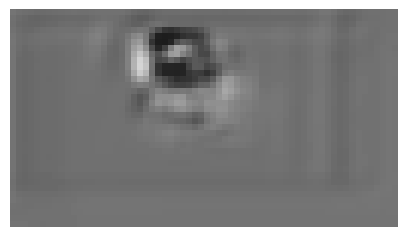

In [37]:
mei, log = GD(sz=sz, 
       step_start=15e3, step_end=8e3, n_epoch=n_epoch,             # 15e3 / 8e3 / 200
       loss_fn=Loss_fn1, fft_filter=fft_filter,                   
       smooth_check=False,
       blurr_check=False, penalty=True,
       blur_start=0.8, blur_end=0.0,         # 0.8 / 0.01
       lambda_1=1 , target_1=16.0,            # 1 / 16       fix std penalty for batch
       lambda_2=1 , target_2=43.5,            # 1 / 38       fix intensity penalty for batch
       batch=batch, neuron=neuron,
       verbose=True, picture=1, save=save,
       data_key="4_7")

#### Closeups

(18.0, 1.0)

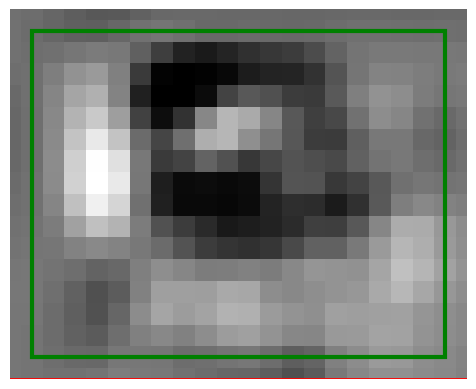

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon

image = mei[0,0,0,:,:].detach().to("cpu")

fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(image, cmap="gray")

# # Create a Rectangle patch
# rect = patches.Rectangle((10, 10), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

fore = np.array([[18,2], [37,2], [37,17],[18,17]])
back = np.array([[39,3], [57,3], [57,31], [12,31], [12,18],[39,18]])

f = Polygon(fore, linewidth=3, edgecolor='g', facecolor='none')
b = Polygon(back, linewidth=2, edgecolor='r', facecolor='none')

# # Add the patch to the Axes
ax.add_patch(f)
ax.add_patch(b)

# Zoom on MEI
# ax.set_xlim([17, 38])
# ax.set_ylim([18, 1])

(-0.5, 20.5, 16.5, -0.5)

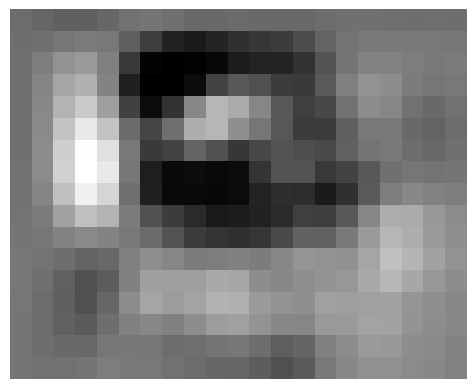

In [39]:
plt.imshow(image[2:19,18:39], cmap="gray")
plt.axis("off")

#### Animations

In [40]:
rows = max(1,batch//2)
save_dir = "./dev/images/"
animation_ddpm = plot_sample(log,batch,rows,save_dir, "ani_run", None, save=save, info=str(neuron), interval=150)
display(HTML(animation_ddpm.to_jshtml()))

# myimshow(log[5][0,0,:,:])

In [41]:
if save:
    np.save(f'./dev/images/log{neuron}.npy', log)